## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

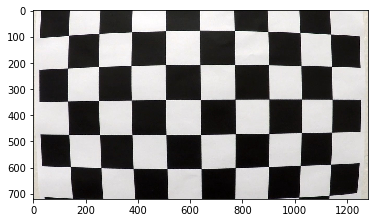

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

#Read the image. 
image = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(image)

## Finding the ChessBoard corners

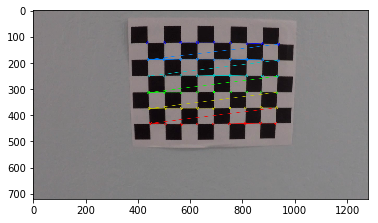

In [3]:
# prepare the object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)

# Undistortion & warped Image:

True


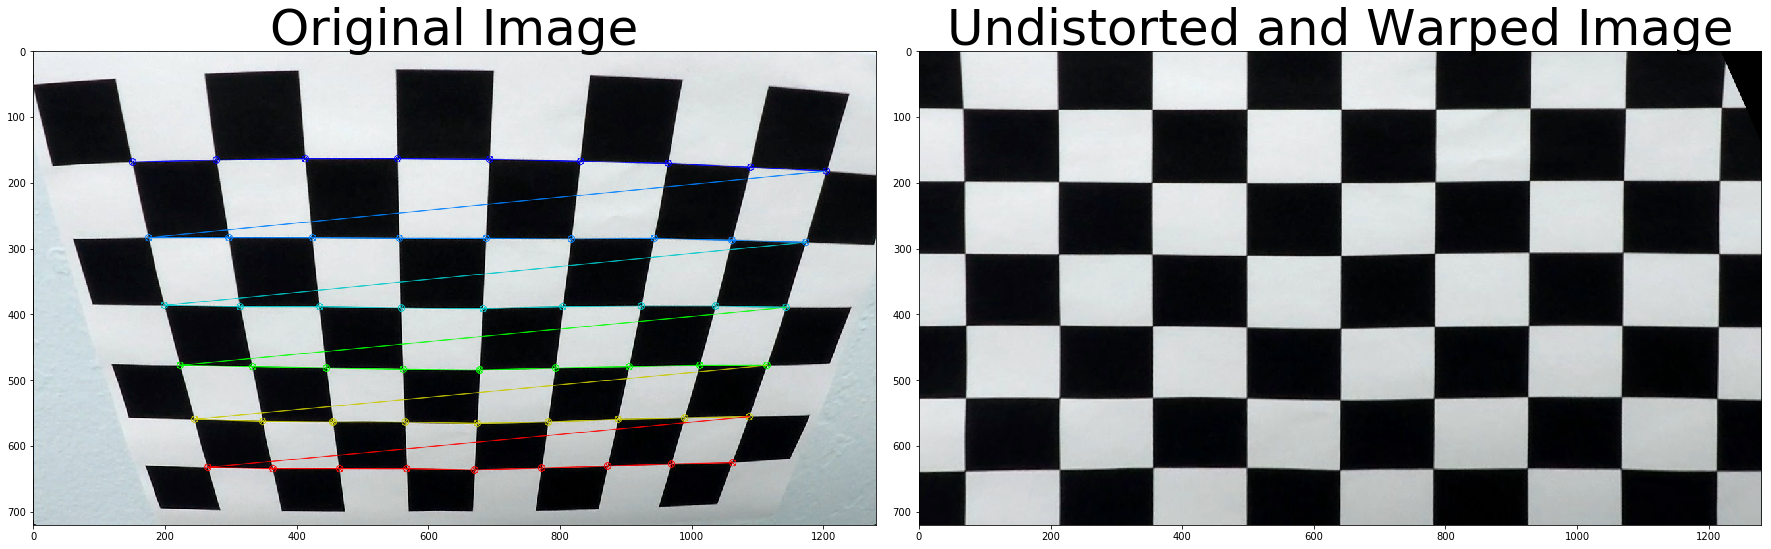

In [4]:
import pickle

# First, we will test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

#Camera calibration on obj & image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

def corners_unwarp(img, nx, ny, mtx, dist):
    
    # Applying cv2.undistort and converting image into Grayscale. 
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #Finding the ChessboardCorners & draw.
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    print(ret)
    if ret == True:
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        offset = 100 
        
        img_size = (gray.shape[1], gray.shape[0])
        
        # Selecting the source points & distination points
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        # Applying the getPerespective Transform & warpPerspective
        M = cv2.getPerspectiveTransform(src, dst)
        
        warped = cv2.warpPerspective(undist, M, img_size)
        
    return warped, M 

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

#Plotting:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Use color transforms, gradients, etc., to create a thresholded binary image.

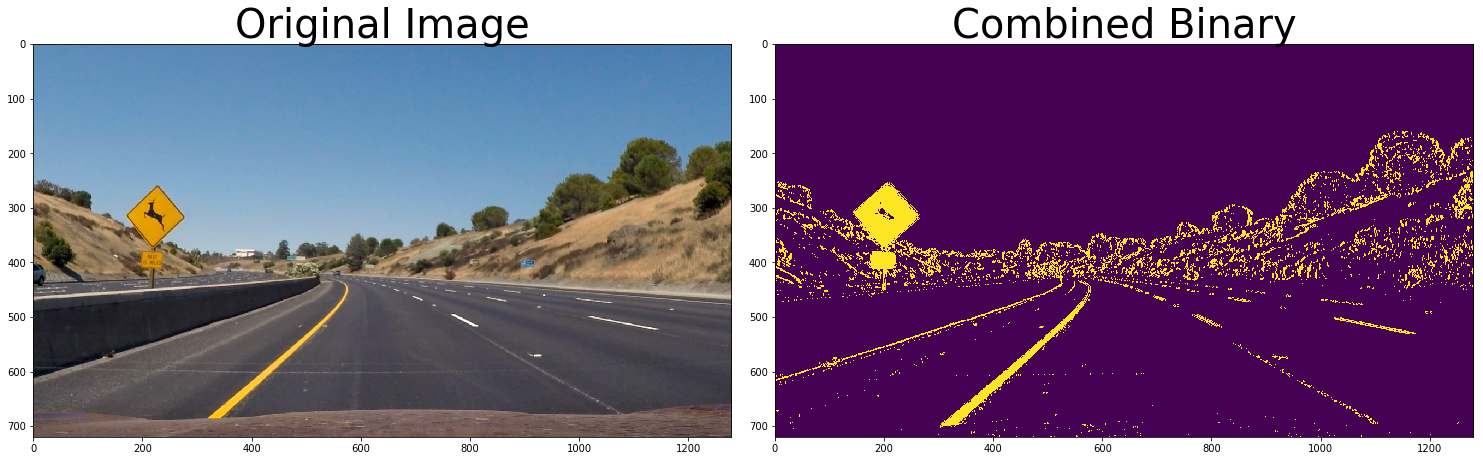

In [5]:
#Read the image.
image = mpimg.imread('test_images/test2.jpg')

def s_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img) #making a copy of the image
    
    #Undistortion of the image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Finding Sobel x, abs_sobelx & scaled_sobel.
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold the x-gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold the color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stacking each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine 2 binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary #returning the combined_binary
    
result = s_binary(image)

# Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Combined Binary', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(result)

plt.savefig('output_images/Combined_Binary_image.jpg')

# Apply a perspective transform to rectify binary image ("birds-eye view").

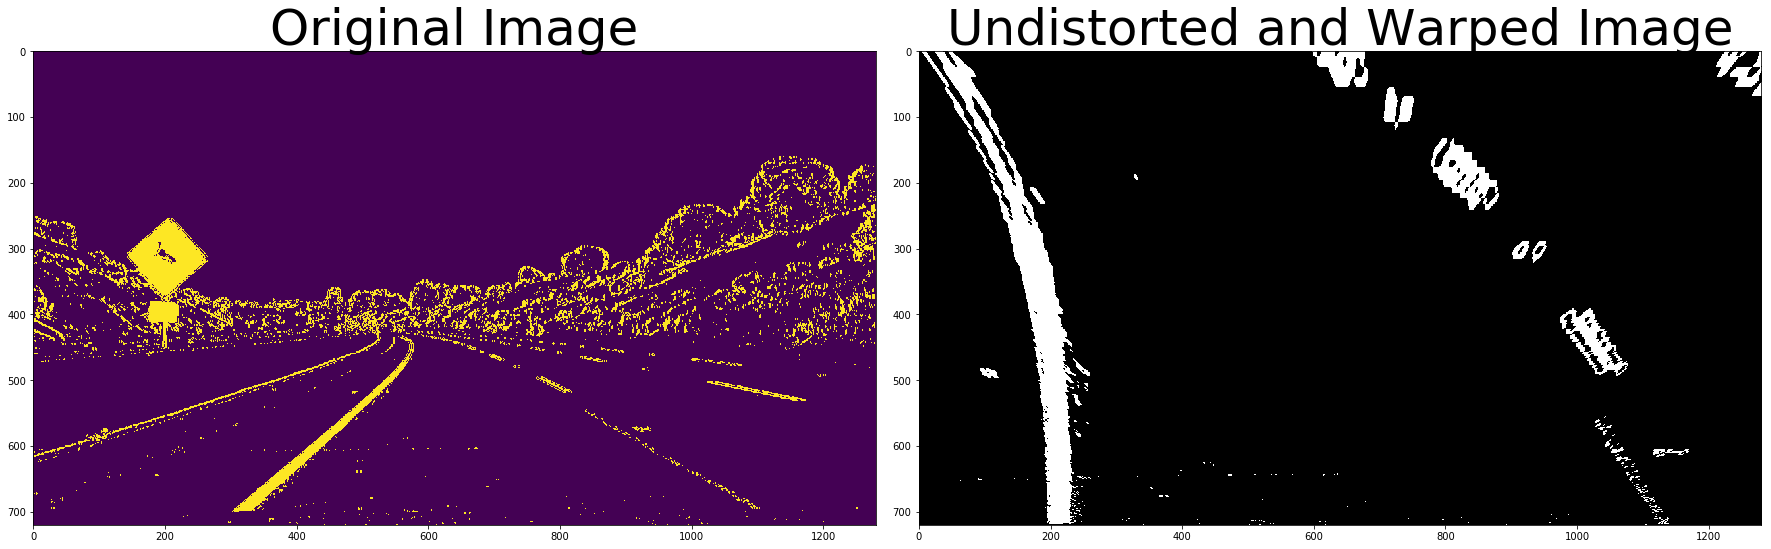

In [6]:
# Read the image.
image = mpimg.imread('test_images/test2.jpg')
img = s_binary(image)

def image_unwarp(img, mtx, dist):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx) # Undistorting the image
    
    img_size = (undist.shape[1], undist.shape[0])
    
    # Giving the source and distination points.
    src = np.float32([[600, 450], [720, 450], [1180, 720], [280, 720]])

    dst = np.float32([[200, 0], [1000, 0], [1180, 720], [200, 720]])
    
    # Applying the getPerespective Transform & warpPerspective
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(undist, M, img_size)

    return warped, Minv

top_down, Minv = image_unwarp(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/Undistorted_Warped_image.jpg')

# Detect lane pixels and fit to find the lane boundary.

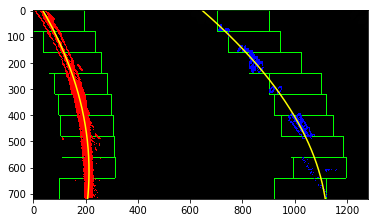

In [7]:
# Load the image from above results
binary_warped, Minv = image_unwarp(img, mtx, dist)

def find_lane_pixels(binary_warped):
    
    # Take a histogram of bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose number of sliding windows
    nwindows = 9
    # Set the width of windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return out_img, left_fitx, right_fitx, ploty

leftx, lefty, rightx, righty, out_image = find_lane_pixels(binary_warped)
out_img, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)

# Plotting ##
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

plt.savefig('output_images/Sliding_Window_image.jpg')

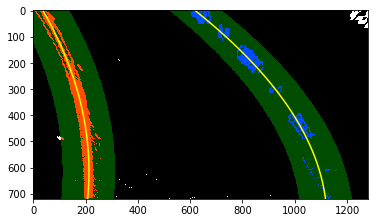

In [8]:
### Fit a second order polynomial to each using `np.polyfit` ###
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty

result, left_fitx, right_fitx, ploty = search_around_poly(binary_warped)

# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
# View your output
plt.imshow(result)

plt.savefig('output_images/Fit__poly_image.jpg')

## Determine the curvature of the lane and vehicle position with respect to center.
## Warp the detected lane boundaries back onto the original image.
## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [18]:
def measure_curvature_real(s_img):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    out_img, leftx, rightx, ploty = fit_polynomial(s_img)

    # Define y-value where we want radius of curvature
    # choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ##### Implement calculation of R_curve (radius of curvature) #####
    ## Implement calculation of the left line here
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    ## Implement calculation of the right line here
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad, ploty

In [19]:
def draw_on_original(img, left_fitx, right_fitx, ploty, Minv):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    pts_left = np.array([np.transpose(np.vstack([left_fitx[400:], ploty[400:]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx[400:], ploty[400:]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    return result

In [20]:
def draw_text(image,car_offset,curvature):
    img = np.copy(image)
    font = cv2.FONT_HERSHEY_DUPLEX
    text_1 = 'Radius of curvature: ' + '{:04.2f}'.format(curvature) + 'm'
    cv2.putText(img, text_1, (50,90), font, 1, (0,255,0), 2, cv2.LINE_AA)
    leftOrRight = ''
    if car_offset > 0:
        leftOrRight = 'right'
    elif car_offset < 0:
        leftOrRight = 'left'
    car_offset = abs(car_offset)
    text_2 = '{:04.3f}'.format(car_offset) + 'm ' + leftOrRight + ' of center'
    cv2.putText(img, text_2, (50,120), font, 1, (0,255,0), 2, cv2.LINE_AA)
    return img

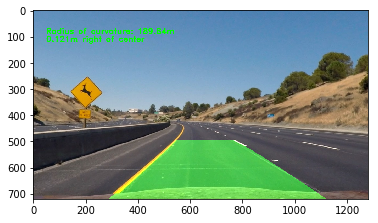

In [21]:
def pipeline(image):
        
    s_img = s_binary(image)
    
    binary_warped, Minv = image_unwarp(s_img, mtx, dist)
    
    result_binary, left_fitx, right_fitx, ploty = search_around_poly(binary_warped)
    
    left_curverad, right_curverad, ploty = measure_curvature_real(s_img)
    
    result = draw_on_original(image, left_fitx, right_fitx, ploty, Minv)
 
    lane_centre = (left_fitx[-1] + right_fitx[-1])/2
    camera_centre = result.shape[1]/2

    car_offset = (lane_centre - camera_centre)*3.7/700
    curvature = (right_curverad + left_curverad)/2
    draw_result = draw_text(result,car_offset,curvature)
    
    return draw_result

input_image = mpimg.imread('test_images/test2.jpg')
output_image = pipeline(input_image)

plt.imshow(output_image)

plt.savefig('output_images/Lane_image.jpg')

In [24]:
# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
from PIL import Image
project_output = 'output_videos/project_video_output.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) 
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [05:11<00:00,  4.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 2min 53s, sys: 11.4 s, total: 3min 5s
Wall time: 5min 14s


In [26]:
harder_output = 'output_videos/harder_video_output.mp4'

clip1 = VideoFileClip('harder_challenge_video.mp4')
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(harder_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_video_output.mp4
[MoviePy] Writing video output_videos/harder_video_output.mp4


100%|█████████▉| 1199/1200 [06:04<00:00,  3.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_video_output.mp4 

CPU times: user 3min 12s, sys: 14.3 s, total: 3min 27s
Wall time: 6min 9s


In [27]:
challenge_output = 'output_videos/challenge_video_output.mp4'

clip1 = VideoFileClip('challenge_video.mp4').subclip(0, 4.5)
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


100%|██████████| 135/135 [00:30<00:00,  4.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 

CPU times: user 17.6 s, sys: 2.55 s, total: 20.2 s
Wall time: 33.6 s
